# Medición de similaridad entre imagenes utilizando redes siamesas

Este cuaderno contiene el código para entrenar y utilizar un modelo de medición de similitud ente imágenes.

Aplicaciones en el problema de pesca:
  - **DeepSORT**: para seguimiento de piezas, se utiliza para usar como complemento al modelo de movimiento en el problema de asignación. Es de interés contar con un extractor especialmente entrenado para las clases de interés (en este caso pescados y operadores).
  - **Búsqueda en video**: dada una imagen con una superficie conteniendo pescados o una red, identificar todos los segmentos en el video en que se presentan escenas similares.

## Introducción

Una red siamesa es una arquitectura de red neuronal que contiene dos o más subredes idénticas utilizadas para generar un vector de características para cada entrada y comparar los mismos.

El objetivo de entrenamiento es computar la distancia entre las dos entradas, minimízándola cuando se trata de imagenes similares y maximizándola cuando no.

Las aplicaciones típicas de este tipo de redes son:

- **Identificación de duplicados**
- **Detección de anomalías**
- **Reconocimiento de rostro** (no confundir con **detección** de rostro).

## Modelo con Triplet loss

En este caso se utiliza un modelo con tres subredes idénticas. La entrada del modelo son tres imagenes, dos de ellas similares (llamadas *anchor* y ejemplo *positivo* y una tercera que no guarda relación, llamada ejemplo *negativo*).

El objetivo del modelo es aprender a estimar la similitud entre imagenes.

La función utilizada en este caso es *triplet loss*, definida como:

$$
L(A, P, N) = (\lVert f(A)-f(P \rVert^2 - \lVert f(A)-f(P \rVert^2 + margin,0)
$$

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [2]:
tf.__version__

'2.5.0'

In [3]:
# Tamaño de la imagen de entrada
INPUT_IMG_SHAPE = (200, 200)

### Obtención del dataset

#### Prueba 1. Con dataset estándar para este problema 

Dataset: [Totally looks like dataset](https://sites.google.com/view/totally-looks-like-dataset)

In [4]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [5]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From: https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
To: /content/left.zip
104MB [00:01, 66.0MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
To: /content/right.zip
104MB [00:00, 157MB/s] 


### Preparación del dataset

Esta implementación usa pipelines con `tf.data`, que es un remplazo de ImageGenerator de Keras.

Más información:
- [tf.data: Fast, flexible, and easy-to-use input pipelines (TensorFlow Dev Summit 2018)](https://www.youtube.com/watch?v=uIcqeP7MFH0)
- [Inside TensorFlow: tf.data - TF Input Pipeline](https://www.youtube.com/watch?v=kVEOCfBy9uY)

Cada pipeline procesa entradas de *(anchor,positive,negative)*.

In [6]:
def preprocess_image(filename, target_shape):
    # ver: https://www.tensorflow.org/tutorials/load_data/images
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative,target_shape):
    return (
        preprocess_image(anchor,target_shape),
        preprocess_image(positive,target_shape),
        preprocess_image(negative,target_shape),
    )

Sets anchor y positive.

In [7]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)
anchor_images[:5]

['/root/.keras/left/00000.jpg',
 '/root/.keras/left/00001.jpg',
 '/root/.keras/left/00002.jpg',
 '/root/.keras/left/00003.jpg',
 '/root/.keras/left/00004.jpg']

In [8]:
positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)
positive_images[:5]

['/root/.keras/right/00000.jpg',
 '/root/.keras/right/00001.jpg',
 '/root/.keras/right/00002.jpg',
 '/root/.keras/right/00003.jpg',
 '/root/.keras/right/00004.jpg']

In [9]:
assert(len(anchor_images)==len(positive_images))
image_count = len(anchor_images)
image_count

6016

In [10]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

El set negativo se construye asignando a cada par *(anchor,positive)* una imagen elegida al azar del set.

In [11]:
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

Preparación del dataset.

In [12]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(lambda anchor, positive, negative: preprocess_triplets(anchor, positive, negative,INPUT_IMG_SHAPE) )

In [13]:
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [14]:
def visualize(anchor, positive, negative,n_samples):
    def show(ax, image,title):
        ax.set_title(title)
        ax.imshow(image, aspect='auto')
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)

    fig,axes = plt.subplots(int(n_samples/2), 6,figsize=(22, n_samples*2))
    for i in range(n_samples):
        iy = int(i/2)
        ix = int(i%2)        
        show(axes[iy, ix*3+0], anchor[i],"anchor")
        show(axes[iy, ix*3+1], positive[i],"positive")
        show(axes[iy, ix*3+2], negative[i],"negative")
        
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0],12)

Output hidden; open in https://colab.research.google.com to view.

### Modelo extractor de características

El objetivo del extractor de features es generar un embedding para cada una de las imagenes de la tupla de entrada *(anchor,positive,negative)*.
El objetivo de la red siamesa es hallar los parámetros óptimos para minimizar la distancia entre anchor y positive, y maximizarla entre anchor y negative.

En este caso se utiliza una red tipo Resnet50 preentrenada y sólo se reentrenan las capas finales (a partir de ´conv5_block1_out´). 

Además se agregan tres capas densas. La última capa contiene el vector de embedding de 256 elementos.

In [15]:
def create_feature_extractor_model():
  base_cnn = resnet.ResNet50(
      weights="imagenet", input_shape=INPUT_IMG_SHAPE + (3,), 
      include_top=False
  )

  flatten = layers.Flatten()(base_cnn.output)
  dense1 = layers.Dense(512, activation="relu")(flatten)
  dense1 = layers.BatchNormalization()(dense1)
  dense2 = layers.Dense(256, activation="relu")(dense1)
  dense2 = layers.BatchNormalization()(dense2)
  output = layers.Dense(256)(dense2)

  feature_extractor_model = Model(base_cnn.input, output, name="Embedding")

  trainable = False
  for layer in base_cnn.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable
      
  return feature_extractor_model

feature_extractor_model = create_feature_extractor_model()
feature_extractor_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "Embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
_________________________

### Modelo de red siamesa

La red siamesa recibirá la tupla *(anchor,positive,negative)* como entrada, generará los embeddings y calculará la distancia entre el anchor y ambos ejemplos. 

No existe en Keras una capa con esta función de distancia, por lo tanto se debe implementar heredando `layers.Layer`.

Más información [Tensorflow guides - Keras - Custom layers and models](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

In [16]:
class DistanceLayer(layers.Layer):
    """ Computar distancia entre anchor y ejemplo positivo y entre anchor y
    ejemplo negativo.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

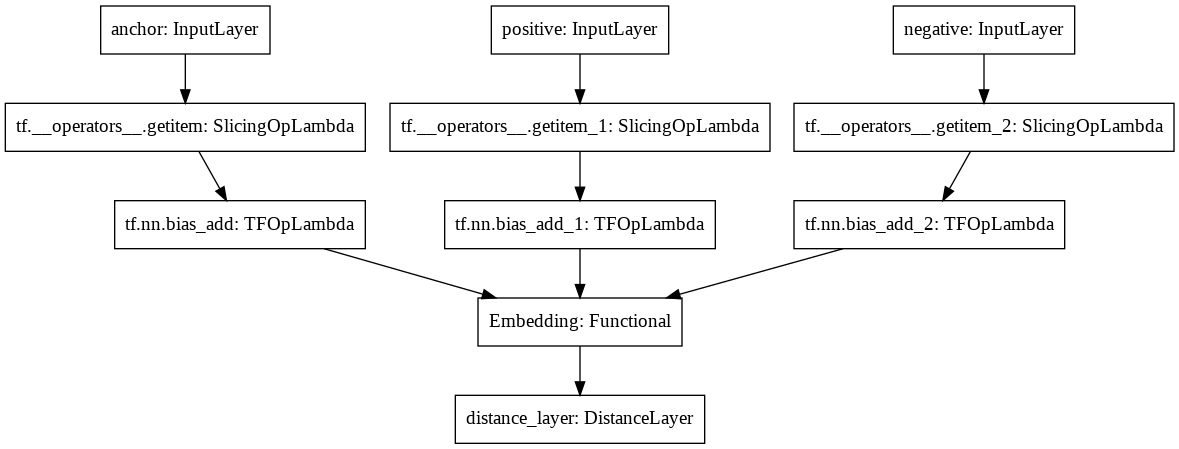

In [17]:
anchor_input = layers.Input(name="anchor", shape=INPUT_IMG_SHAPE + (3,))
positive_input = layers.Input(name="positive", shape=INPUT_IMG_SHAPE + (3,))
negative_input = layers.Input(name="negative", shape=INPUT_IMG_SHAPE + (3,))

distances = DistanceLayer()(
    feature_extractor_model(resnet.preprocess_input(anchor_input)),
    feature_extractor_model(resnet.preprocess_input(positive_input)),
    feature_extractor_model(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

tf.keras.utils.plot_model(siamese_network)

In [18]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 200, 200, 3)  0           anchor[0][0]                     
______________________________________________________________________________________________

### Customización de función de entrenamiento

Las capas custom requieren implementar los pasos de entrenamiento de actualizar los gradientes y evaluar en el set de validación.

In [19]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

### Entrenamiento

In [20]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
151/151 [==============================] - 204s 1s/step - loss: 0.5044 - val_loss: 0.3797
Epoch 2/10
151/151 [==============================] - 158s 1s/step - loss: 0.4017 - val_loss: 0.3471
Epoch 3/10
151/151 [==============================] - 158s 1s/step - loss: 0.3620 - val_loss: 0.3358
Epoch 4/10
151/151 [==============================] - 158s 1s/step - loss: 0.3506 - val_loss: 0.3343
Epoch 5/10
151/151 [==============================] - 159s 1s/step - loss: 0.3453 - val_loss: 0.3331
Epoch 6/10
151/151 [==============================] - 158s 1s/step - loss: 0.3309 - val_loss: 0.3211
Epoch 7/10
151/151 [==============================] - 157s 1s/step - loss: 0.3255 - val_loss: 0.3131
Epoch 8/10
151/151 [==============================] - 157s 1s/step - loss: 0.3091 - val_loss: 0.3131
Epoch 9/10
151/151 [==============================] - 157s 1s/step - loss: 0.2878 - val_loss: 0.2946
Epoch 10/10
151/151 [==============================] - 157s 1s/step - loss: 0.2887 - val_lo

### Inferencia

In [21]:
sample = next(iter(train_dataset))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    feature_extractor_model.predict(resnet.preprocess_input(anchor)),
    feature_extractor_model.predict(resnet.preprocess_input(positive)),
    feature_extractor_model.predict(resnet.preprocess_input(negative)),
)

In [22]:
n_samples = 32
fig,axes = plt.subplots(n_samples,3,figsize=(22,n_samples*6))

for i in range(n_samples):
  cosine_similarity = metrics.CosineSimilarity()
  positive_similarity = cosine_similarity(anchor_embedding[i], positive_embedding[i]).numpy()
  negative_similarity = cosine_similarity(anchor_embedding[i], negative_embedding[i]).numpy()
  positive_similarity,negative_similarity

  axes[i][0].set_title("Anchor")
  axes[i][0].imshow(anchor[i],aspect='auto')
  axes[i][1].imshow(positive[i],aspect='auto')
  axes[i][1].set_title("Positive {:3f}".format(positive_similarity))
  axes[i][2].imshow(negative[i],aspect='auto')
  axes[i][2].set_title("Negative {:3f}".format(negative_similarity))

fig.tight_layout()

### Exportación del modelo

In [23]:
MODEL_NAME='feature_extractor_ll'
MODELS_PATH='saved_model/'
!rm -rf {MODELS_PATH}/{MODEL_NAME}
!mkdir -pv {MODELS_PATH}/{MODEL_NAME}
feature_extractor_model.save(MODELS_PATH+MODEL_NAME)
!tar -czvf {MODEL_NAME}.tar.gz {MODELS_PATH}/{MODEL_NAME}

mkdir: created directory 'saved_model'
mkdir: created directory 'saved_model//feature_extractor_ll'


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_model/feature_extractor_ll/assets
saved_model//feature_extractor_ll/
saved_model//feature_extractor_ll/saved_model.pb
saved_model//feature_extractor_ll/variables/
saved_model//feature_extractor_ll/variables/variables.data-00000-of-00001
saved_model//feature_extractor_ll/variables/variables.index
saved_model//feature_extractor_ll/keras_metadata.pb
saved_model//feature_extractor_ll/assets/


### Importación y uso en datos nuevos

In [24]:
fe = tf.keras.models.load_model(
    MODELS_PATH+MODEL_NAME, 
    custom_objects=None, 
    compile=True, 
    options=None
)

In [25]:
sample = next(iter(train_dataset))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    fe.predict(resnet.preprocess_input(anchor)),
    fe.predict(resnet.preprocess_input(positive)),
    fe.predict(resnet.preprocess_input(negative)),
)

In [ ]:
n_samples = 32
fig,axes = plt.subplots(n_samples,3,figsize=(22,n_samples*6))

for i in range(n_samples):
  cosine_similarity = metrics.CosineSimilarity()
  positive_similarity = cosine_similarity(anchor_embedding[i], positive_embedding[i]).numpy()
  negative_similarity = cosine_similarity(anchor_embedding[i], negative_embedding[i]).numpy()
  positive_similarity,negative_similarity

  axes[i][0].set_title("Anchor")
  axes[i][0].imshow(anchor[i],aspect='auto')
  axes[i][1].imshow(positive[i],aspect='auto')
  axes[i][1].set_title("Positive {:3f}".format(positive_similarity))
  axes[i][2].imshow(negative[i],aspect='auto')
  axes[i][2].set_title("Negative {:3f}".format(negative_similarity))

fig.tight_layout()

### Aplicación: Buscar imagenes similares en un video

In [ ]:
import cv2

TEST_VIDEO_FILENAME = 'langostino_rawson.mp4'

In [ ]:
def read_single_frame_from_video(filename, frame_index=None,frame_time=None):
  assert(frame_index is not None or frame_time is not None)
  cap = cv2.VideoCapture(filename)
  cap.set(cv2.CAP_PROP_POS_FRAMES,frame_index);
  ret, frame = cap.read()
  frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)
  cap.release()
  return frame

In [ ]:
anchor_frame = read_single_frame_from_video(TEST_VIDEO_FILENAME,2000)
plt.imshow(anchor_frame)

error: ignored

In [ ]:
def scan_video_for_similar_frames(filename,anchor_frame,start_frame,max_frames):
  cap = cv2.VideoCapture(filename)
  cap.set(cv2.CAP_PROP_POS_FRAMES,start_frame);
  fps = cap.get(cv2.CAP_PROP_FPS)

  extractor_input_shape=(200,200)
  
  if max_frames is None:
    max_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  
  anchor_embedding = fe.predict(resnet.preprocess_input(tf.image.resize( np.expand_dims(anchor_frame,axis=0), extractor_input_shape )))
  
  results = []
  for i in range(max_frames):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)
    frame_embedding = fe.predict(resnet.preprocess_input(tf.image.resize( np.expand_dims(frame,axis=0), extractor_input_shape )))
    similarity = cosine_similarity(anchor_embedding, frame_embedding).numpy()
    frame_index = start_frame+i
    results.append([frame_index/fps,similarity])
  cap.release()
  return np.array(results)

similarity = scan_video_for_similar_frames(filename=TEST_VIDEO_FILENAME,
                                           anchor_frame=anchor_frame,
                                           start_frame=0,
                                           max_frames=None)

fig,axes = plt.subplots(1,1,figsize=(18,6))
axes.plot(similarity[:,0],similarity[:,1])
axes.set_xlabel("Offset en video [s]")
axes.set_ylabel("Similaridad")
axes.grid(which="Both")
axes.set_title("Similaridad");

## Referencias

- https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/siamese_network.ipynb#scrollTo=bBj2XlPW5xkS
- https://colab.research.google.com/github/GreatLearningAIML1/chennai-aug-batch-npar9999/blob/master/R10_ExternalLab.ipynb
- [Image similarity using Triplet Loss](https://towardsdatascience.com/image-similarity-using-triplet-loss-3744c0f67973)

Funciones de optimización custom:
- [Introduction to Keras for researchers](https://keras.io/getting_started/intro_to_keras_for_researchers/)
- [Writing a custom training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=en)